In [30]:
import argparse
from scipy.optimize import curve_fit
import ConfigSpace
import logging
import matplotlib.pyplot as plt
import pandas as pd
from abc import ABC
import numpy as np
from sklearn.pipeline import Pipeline
import typing

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Surrogate Model

In [31]:
import sklearn.impute
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import pandas as pd
from scipy.stats import spearmanr

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class SurrogateModel:

    def __init__(self, config_space):
        self.config_space = config_space
        self.df = None
        self.model = None
        self.x = None
    def fit(self, df):
        """
        Receives a data frame, in which each column (except for the last two) represents a hyperparameter, the
        penultimate column represents the anchor size, and the final column represents the performance.

        :param df: the dataframe with performances
        :return: Does not return anything, but stores the trained model in self.model
        """
        self.df = df
        x = df.iloc[:, :-1]
        y = df.iloc[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        # fit the external surrogate model using OneHotEncoder
        categorical_features = x.select_dtypes(include=['object']).columns.tolist()
        numerical_features = x.select_dtypes(include=['number']).columns.tolist()
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', sklearn.impute.SimpleImputer(strategy='mean'), numerical_features),
                ('cat', OneHotEncoder(), categorical_features)
            ])

        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=1000, random_state=40))
        ])
        model.fit(x_train, y_train)
        self.model = model

        pred = model.predict(x_test)
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        corr, _ = spearmanr(y_test, pred)
        print(f"External surrogate Model Evaluation: - MSE: {mse:.4f}, R2: {r2:.4f}")
        print(f"Spearman Correlation: {corr:.4f}")
        self.x = x
        self.model.fit(x, y)


    def predict(self, theta_new):
        """
        Predicts the performance of a given configuration theta_new

        :param theta_new: a dict, where each key represents the hyperparameter (or anchor)
        :return: float, the predicted performance of theta new (which can be considered the ground truth)
        """
        if self.model == None:
            raise ValueError("Train the model first.")
        # fill the keys without full dictionary with default values of the config space
        else:
            for key in dict(self.config_space).keys():
                if key not in theta_new.keys():
                    theta_new[key] = dict(self.config_space)[key].default_value
            list_theta = [theta_new]
            x_pred = pd.DataFrame(list_theta)
            x_pred = x_pred[self.df.keys()[:-1]]
        # predict the performance as ground truth

            y_pred = self.model.predict(x_pred)
            return y_pred[0]

# VerticalModelEvaluator

In [32]:
class VerticalModelEvaluator(ABC):

    def __init__(self, surrogate_model: Pipeline, minimal_anchor: int, final_anchor: int) -> None:
        """
        Initialises the vertical model evaluator. Take note of what the arguments are

        :param surrogate_model: A sklearn pipeline object, which has already been fitted on LCDB data. You can use the predict model to predict for a numpy array (consisting of configuration information and an anchor size) what the performance of that configuration is.
        :param minimal_anchor: Smallest anchor to be used
        :param final_anchor: Largest anchor to be used
        """
        self.surrogate_model = surrogate_model
        self.minimal_anchor = minimal_anchor
        self.final_anchor = final_anchor

    def evaluate_model(self, best_so_far: float, configuration: typing.Dict) -> typing.List[float]:
        raise NotImplemented()


# LCCV

In [33]:
class LCCV(VerticalModelEvaluator):

    @staticmethod
    def optimistic_extrapolation(
        previous_anchor: int,
        previous_performance: float,
        current_anchor: int,
        current_performance: float,
        target_anchor: int,
    ) -> float:
        """
        Does the optimistic performance. Since we are working with a simplified
        surrogate model, we can not measure the infimum and supremum of the
        distribution. Just calculate the slope between the points, and
        extrapolate this.

        :param previous_anchor: See name
        :param previous_performance: Performance at previous anchor
        :param current_anchor: See name
        :param current_performance: Performance at current anchor
        :param target_anchor: the anchor at which we want to have the
        optimistic extrapolation
        :return: The optimistic extrapolation of the performance
        """
        op_perf = current_performance + (target_anchor - previous_anchor) * (
            previous_performance - current_performance
        ) / (previous_anchor - current_anchor)

        return op_perf

    def evaluate_model(
        self, best_so_far: typing.Optional[float], configuration: typing.Dict
    ) -> typing.List[typing.Tuple[int, float]]:
        """
        Does a staged evaluation of the model, on increasing anchor sizes.
        Determines after the evaluation at every anchor an optimistic
        extrapolation. In case the optimistic extrapolation can not improve
        over the best so far, it stops the evaluation.
        In case the best so far is not determined (None), it evaluates
        immediately on the final anchor (determined by self.final_anchor)

        :param best_so_far: indicates which performance has been obtained so far
        :param configuration: A dictionary indicating the configuration

        :return: A tuple of the evaluations that have been done. Each element of
        the tuple consists of two elements: the anchor size and the estimated
        performance.
        """
        if best_so_far is None:
            configuration["anchor_size"] = self.final_anchor
            best_so_far = self.surrogate_model.predict(configuration)

        anchor_sizes = [
            x
            for x in self.surrogate_model.x.anchor_size.unique()
            if x >= self.minimal_anchor
        ]

        # anchor_sizes = [x for x in range(self.minimal_anchor, self.final_anchor)]
        configuration["anchor_size"] = anchor_sizes[0]
        performances = [self.surrogate_model.predict(configuration)]
        results = [(anchor_sizes[0], performances[0])]

        i = 1
        while i < len(anchor_sizes):
            current_anchor = anchor_sizes[i]
            configuration["anchor_size"] = current_anchor
            current_performance = self.surrogate_model.predict(configuration)
            performances.append(current_performance)

            previous_anchor = anchor_sizes[i - 1]
            previous_performance = performances[i - 1]

            op_perf = self.optimistic_extrapolation(
                previous_anchor=previous_anchor,
                previous_performance=previous_performance,
                current_anchor=current_anchor,
                current_performance=current_performance,
                target_anchor=self.final_anchor,
            )

            results.append((current_anchor, current_performance))

            if best_so_far is not None and op_perf >= best_so_far:
                break

            i += 1

        return results


# IPL

In [34]:
class IPL(VerticalModelEvaluator):

    @staticmethod
    def probability_extrapolation(x, c, a, alpha) -> float:
        """
        Does the optimistic performance. Since we are working with a simplified
        surrogate model, we can not measure the infimum and supremum of the
        distribution. Just calculate the slope between the points, and
        extrapolate this.

        :param previous_anchor: See name
        :param previous_performance: Performance at previous anchor
        :param current_anchor: See name
        :param current_performance: Performance at current anchor
        :param target_anchor: the anchor at which we want to have the
        optimistic extrapolation
        :return: The optimistic extrapolation of the performance
        """

        # pow3
        # op_perf = c - a * x ** (-alpha)
        op_perf = c + a * x ** (-alpha)
        # vapor pressure
        # op_perf = np.exp(kwargs["a"] + kwargs["b"] / kwargs["x"] + kwargs["c"] * np.log(kwargs["x"]))
        return op_perf

    # def fit(self, anchor_sizes, performances):
    #     init_param = [np.min(performances), 0.1, 0.5]
    #     # init_param = [np.mean(performances), 0.01, 0.05]
    #     opt_param, cov_mat_param = curve_fit(
    #         self.probability_extrapolation,
    #         anchor_sizes,
    #         performances,
    #         p0=init_param,
    #         maxfev=10000,
    #         # bounds=([0, 0, 0], [1, 1, 10]),
    #     )
    #     print(opt_param)
    #     return opt_param

    def fit(self, anchor_sizes, performances):
        anchor_sizes = anchor_sizes
        performances = performances
        best_popt = None
        best_error = float("inf")

        initial_c = np.mean(performances)
        # initial_c = np.min(performances)
        initial_guesses = [
            [initial_c, 1.0, 0.7],
            [initial_c * 0.8, 0.5, 0.5],
            [initial_c * 1.2, 1.0, 0.5],
            # [performances[-1], performances[1] - performances[0], 0.5],
            # [performances[-1], 1.0, 0.5],
            # [performances[-1] * 0.8, 2.0, 0.7],
            # [performances[-1] * 1.2, 0.5, 0.3],
        ]
        # choose the best initial_guesses
        for initial_guess in initial_guesses:
            # try:
            popt, _ = curve_fit(
                self.probability_extrapolation,
                anchor_sizes,
                performances,
                p0=initial_guess,
                maxfev=50000,
                # bounds=([0, 0, 0], [1, 1, 10]),
            )

            residuals = performances - self.probability_extrapolation(
                anchor_sizes, *popt
            )
            error = np.sum(residuals**2)

            if error < best_error:
                best_error = error
                best_popt = popt
            # except RuntimeError:
            #     continue
        if best_popt is None:
            best_popt = initial_guesses[0]
        return best_popt

    # self.c, self.a, self.alpha = best_popt

    def evaluate_model(
        self, best_so_far: typing.Optional[float], configuration: typing.Dict
    ) -> typing.List[typing.Tuple[int, float]]:
        """
        Does a staged evaluation of the model, on increasing anchor sizes.
        Determines after the evaluation at every anchor an optimistic
        extrapolation. In case the optimistic extrapolation can not improve
        over the best so far, it stops the evaluation.
        In case the best so far is not determined (None), it evaluates
        immediately on the final anchor (determined by self.final_anchor)

        :param best_so_far: indicates which performance has been obtained so far
        :param configuration: A dictionary indicating the configuration

        :return: A tuple of the evaluations that have been done. Each element of
        the tuple consists of two elements: the anchor size and the estimated
        performance.
        """
        if best_so_far is None:
            configuration["anchor_size"] = self.final_anchor
            best_so_far = self.surrogate_model.predict(configuration)

        percentage_datasets = 0.5
        anchor_sizes = [
            self.surrogate_model.x.anchor_size[x]
            for x in range(
                int(
                    len(self.surrogate_model.x.anchor_size.unique())
                    * percentage_datasets
                )
            )
        ]
        performances = []
        results = []
        for i in range(len(anchor_sizes)):

            configuration["anchor_size"] = anchor_sizes[i]
            performances.append(self.surrogate_model.predict(configuration))

            results.append((anchor_sizes[i], performances[i]))

        c, a, alpha = self.fit(anchor_sizes=anchor_sizes, performances=performances)
        x = self.final_anchor
        estimated_performance = self.probability_extrapolation(
            c=c, a=a, x=x, alpha=alpha
        )

        if estimated_performance > best_so_far:

            return results
        else:
            configuration["anchor_size"] = self.final_anchor
            final_performance = self.surrogate_model.predict(configuration)
            results.append((self.final_anchor, final_performance))
            return results

# Experiment

In [35]:
def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument(
        "--config_space_file", type=str, default="lcdb_config_space_knn.json"
    )
    parser.add_argument(
        "--configurations_performance_file_1",
        type=str,
        default="config_performances_dataset-6.csv",
    )
    parser.add_argument(
        '--configurations_performance_file_2',
        type=str,
        default='config_performances_dataset-11.csv')
    parser.add_argument(
        '--configurations_performance_file_3',
        type=str,
        default='config_performances_dataset-1457.csv')
    # max_anchor_size: connected to the configurations_performance_file. The max value upon which anchors are sampled
    parser.add_argument("--minimal_anchor_1", type=int, default=724)
    parser.add_argument("--minimal_anchor_2", type=int, default=23)
    parser.add_argument("--minimal_anchor_3", type=int, default=64)
    parser.add_argument("--max_anchor_size_1", type=int, default=16000)
    parser.add_argument("--max_anchor_size_2", type=int, default=500)
    parser.add_argument("--max_anchor_size_3", type=int, default=1200)
    parser.add_argument("--num_iterations", type=int, default=100)

    return parser.parse_known_args()[0]


def run(args):
    config_space = ConfigSpace.ConfigurationSpace.from_json(args.config_space_file)
    df = pd.read_csv(args.configurations_performance_file)
    surrogate_model = SurrogateModel(config_space)
    surrogate_model.fit(df)
    lccv = LCCV(surrogate_model, args.minimal_anchor, args.max_anchor_size)
    ipl = IPL(surrogate_model, args.minimal_anchor, args.max_anchor_size)
    best_so_far_lccv = None
    best_so_far_ipl = None
    best_so_far_random = None
    accumulated_anchor_size_lccv = 0
    accumulated_anchor_size_ipl = 0
    accumulated_anchor_size_random = 0
    results = {"LCCV": [], "IPL": [], "Random_Search": []}
    x_values_lccv = []
    y_values_lccv = []
    x_values_ipl = []
    y_values_ipl = []

    for idx in range(args.num_iterations):

        theta_new = dict(config_space.sample_configuration())
        # run LCCV
        xy_values_lccv = []
        result_lccv = lccv.evaluate_model(best_so_far_lccv, theta_new)
        for anchor, _ in result_lccv:
            accumulated_anchor_size_lccv += anchor

        final_result_lccv = result_lccv[-1][1]
        if best_so_far_lccv is None or final_result_lccv < best_so_far_lccv:
            best_so_far_lccv = final_result_lccv
        x_values_lccv.append([i[0] for i in result_lccv])
        y_values_lccv.append([i[1] for i in result_lccv])
        results["LCCV"].append(best_so_far_lccv)

        # plt.plot(x_values_lccv, y_values_lccv, "-o")
        xy_values_lccv.append((x_values_lccv, y_values_lccv))

        # run IPL
        xy_values_ipl = []
        result_ipl = ipl.evaluate_model(best_so_far_ipl, theta_new)
        for anchor, _ in result_ipl:
            accumulated_anchor_size_ipl += anchor
        final_result_ipl = result_ipl[-1][1]
        if best_so_far_ipl is None or final_result_ipl < best_so_far_ipl:
            best_so_far_ipl = final_result_ipl
        x_values_ipl.append([i[0] for i in result_ipl])
        y_values_ipl.append([i[1] for i in result_ipl])
        results["IPL"].append(best_so_far_ipl)
        # plt.plot(x_values_ipl, y_values_ipl, "-o")
        xy_values_ipl.append((x_values_ipl, y_values_ipl))

        # run random search

        theta_new["anchor_size"] = args.max_anchor_size
        performance_random = surrogate_model.predict(theta_new=theta_new)
        accumulated_anchor_size_random += args.max_anchor_size
        if best_so_far_random is None or performance_random < best_so_far_random:
            best_so_far_random = performance_random
        results["Random_Search"].append(best_so_far_random)



    plt.figure()
    for x_values, y_values in xy_values_lccv:
        for i in range(len(x_values)):
            plt.plot(x_values[i], y_values[i], "-o")
    plt.title(
        "LCCV\nBest Performance:{:.4f}, Accumulated Anchor Size:{}".format(
            best_so_far_lccv, accumulated_anchor_size_lccv
        )
    )
    plt.xlabel("Anchor Size")
    plt.ylabel("Performance")
    plt.show()

    plt.figure()
    for x_values, y_values in xy_values_ipl:
        for i in range(len(x_values)):
            plt.plot(x_values[i], y_values[i], "-o")
    plt.title(
        "IPL\nBest Performance:{:.4f}, Accumulated Anchor Size:{}".format(
            best_so_far_ipl, accumulated_anchor_size_ipl
        )
    )
    plt.xlabel("Anchor Size")
    plt.ylabel("Performance")
    plt.show()

    plt.figure()
    plt.plot(
        range(len(results["LCCV"])),
        results["LCCV"],
        label="LCCV",
    )
    plt.plot(
        range(len(results["IPL"])),
        results["IPL"],
        label="IPL",
    )
    plt.plot(
        range(len(results["Random_Search"])),
        results["Random_Search"],
        label="Random Search",
    )
    plt.title(
        "Comparison of Performance\n LCCV Best ={:.4f}, IPL Best ={:.4f}, Random Best ={:.4f}".format(
            best_so_far_lccv, best_so_far_ipl, best_so_far_random
        )
    )
    plt.xlabel("Iterations")
    plt.ylabel("Performance")
    plt.legend()
    plt.show()

    x_labels = ["LCCV", "IPL", "Random Search"]
    x_positions = range(len(x_labels))  # [0, 1, 2]
    y_values = [
        accumulated_anchor_size_lccv,
        accumulated_anchor_size_ipl,
        accumulated_anchor_size_random,
    ]

    plt.figure()
    plt.bar(x_positions, y_values, color=["blue", "green", "orange"])
    plt.title(
        "Comparison of Accumulated Anchor Size\n LCCV={}, IPL={}, Random={}".format(
            accumulated_anchor_size_lccv,
            accumulated_anchor_size_ipl,
            accumulated_anchor_size_random,
        )
    )
    plt.xticks(x_positions, x_labels)
    plt.ylabel("Accumulated Anchor Size")
    plt.show()


In [36]:
def run_for_all_files(args):
    configurations_files = [
        args.configurations_performance_file_1,
        args.configurations_performance_file_2,
        args.configurations_performance_file_3,
    ]
    minimal_anchors = [
        args.minimal_anchor_1,
        args.minimal_anchor_2,
        args.minimal_anchor_3,
    ]
    max_anchor_sizes = [
        args.max_anchor_size_1,
        args.max_anchor_size_2,
        args.max_anchor_size_3,
    ]
    dataset = ['dataset-6', 'dataset-11', 'dataset-1457']
    for i in range(len(configurations_files)):
        print(f"Running for configuration file {dataset[i]}...")
        args.configurations_performance_file = configurations_files[i]
        args.minimal_anchor = minimal_anchors[i]
        args.max_anchor_size = max_anchor_sizes[i]

        run(args)

Running for configuration file dataset-6...
External surrogate Model Evaluation: - MSE: 0.0000, R2: 0.9998
Spearman Correlation: 0.9998


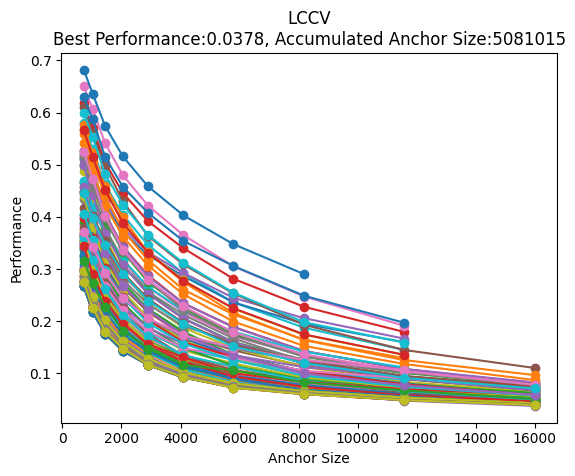

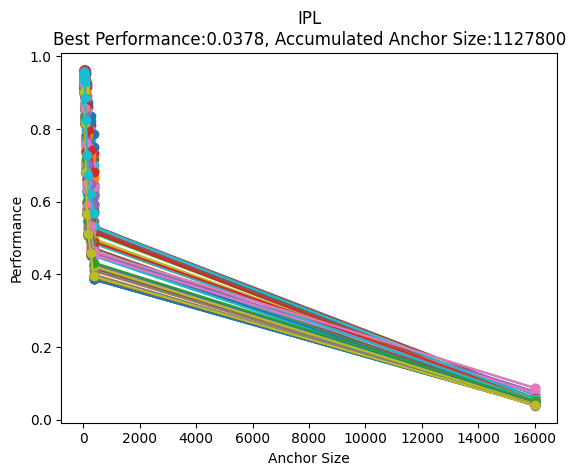

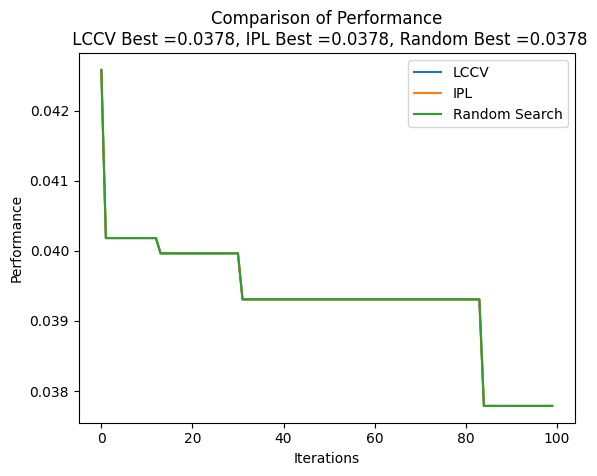

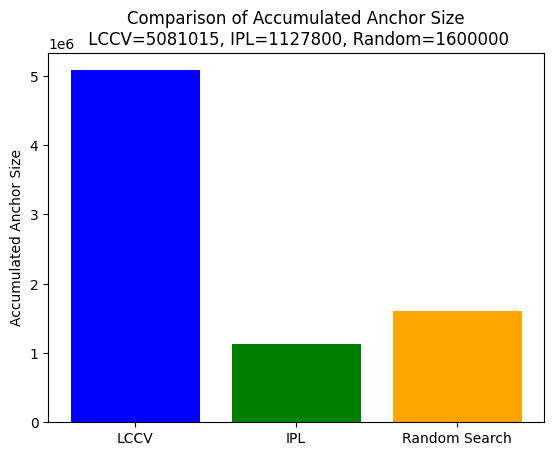

Running for configuration file dataset-11...
External surrogate Model Evaluation: - MSE: 0.0000, R2: 0.9986
Spearman Correlation: 0.9983


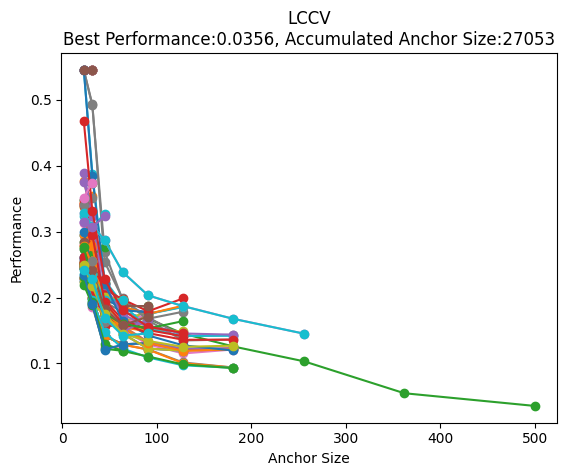

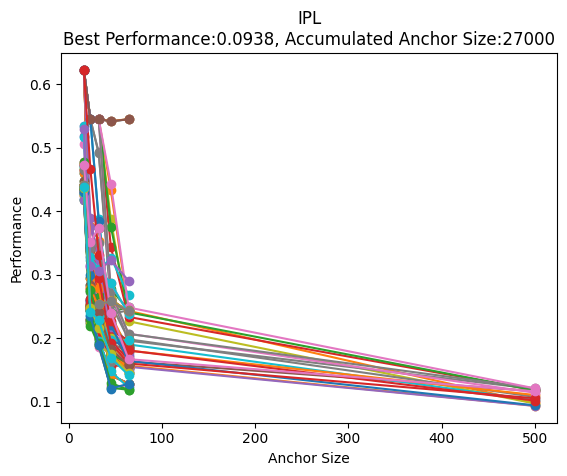

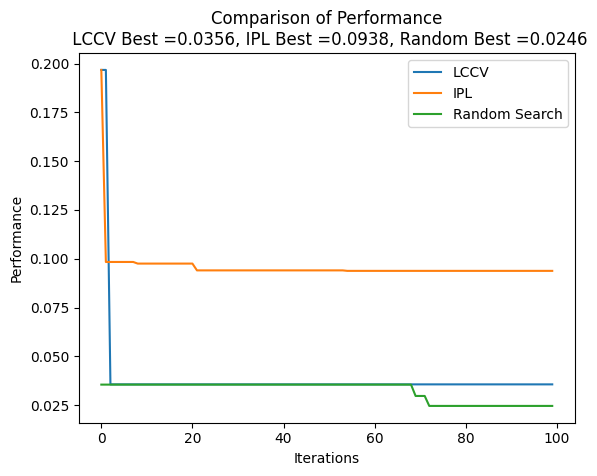

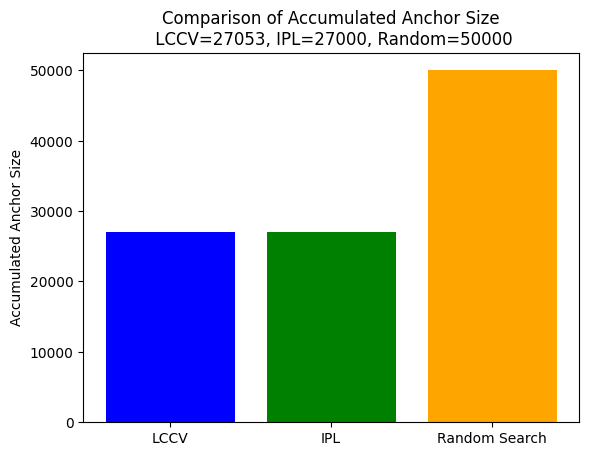

Running for configuration file dataset-1457...
External surrogate Model Evaluation: - MSE: 0.0000, R2: 0.9969
Spearman Correlation: 0.9891


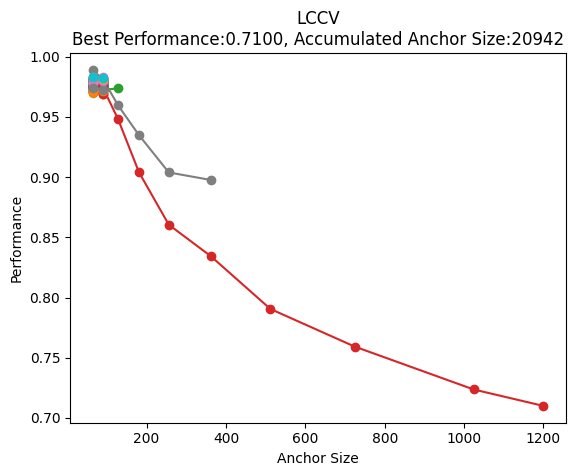

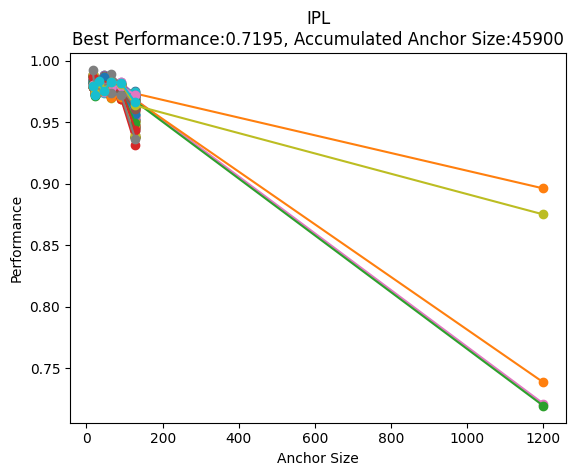

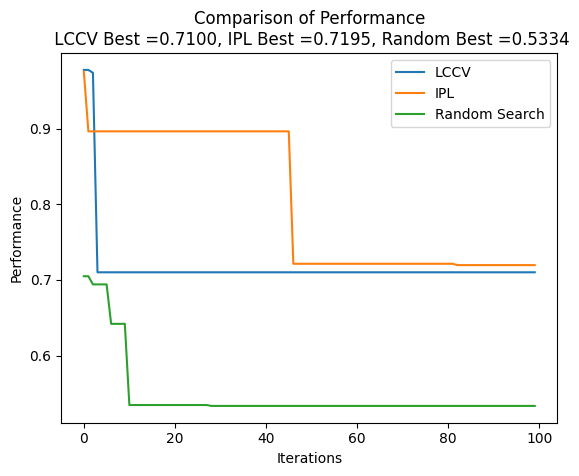

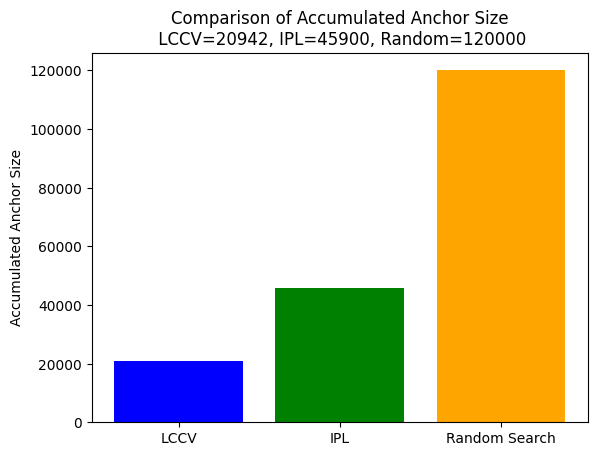

In [37]:
args = parse_args()
run_for_all_files(args)